In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [117]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import metrics


In [7]:
df = pd.read_csv("/Users/alinamazi/Documents/Data/NYC-Taxi-sample/train.csv")
df_test = pd.read_csv("/Users/alinamazi/Documents/Data/NYC-Taxi-sample/test.csv")

df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [8]:
print (df.shape, df_test.shape)

((1458644, 11), (625134, 9))


In [92]:
print(df["trip_duration"].min(),df["trip_duration"].mean(),df["trip_duration"].max())

(1, 959.49227296036588, 3526282)


In [17]:
print(np.min(df["pickup_latitude"]), np.max(df['pickup_latitude']))
print(np.min(df["dropoff_latitude"]), np.max(df['dropoff_latitude']))

print(np.min(df["pickup_longitude"]), np.max(df['pickup_longitude']))
print(np.min(df["dropoff_longitude"]), np.max(df['dropoff_longitude']))

NYC = x_range, y_range = ((-121.93334197998048, -61.335529327392578), (32.181140899658203, 51.881084442138672))

In [155]:
# let's plot 10k sample pickup
samples = df.sample(n=10000)
samples['log_trip_duration'] = np.log(samples["trip_duration"].values + 1)
y = samples["log_trip_duration"].tolist()
# samples['log_trip_duration'].tolist()[:5]

X_train, X_test, y_train, y_test = train_test_split(samples,y)

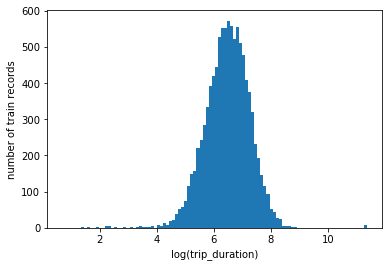

In [163]:
plt.hist(samples['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [50]:
from sklearn import base

class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        l = []
        for index,row in X.iterrows():
            cols = []
            for c in self.col_names:
#                 print c
#                 print row[c]
                cols.append(row[c])
                #print c
            l.append(cols)
            
        return l

In [67]:
cst = ColumnSelectTransformer(['pickup_longitude', 'pickup_latitude'])
assert(cst.fit_transform(df.loc[:0]) == [[df.loc[0]['pickup_longitude'], df.loc[0]['pickup_latitude']]])

In [121]:
def r2_secret(estimator, X_test, y_test):
    predictions = estimator.predict(X_test)
#     secret_mses.append(mean_squared_error(y_test, predictions))
    return metrics.r2_score(y_test, predictions)


In [160]:

scores = []
# for i in range(1,10):
pipe_ll = Pipeline([('ColumnSelectTransformer',ColumnSelectTransformer(['pickup_longitude', 'pickup_latitude','dropoff_longitude','dropoff_latitude'])),
#              ('KNeighborsRegressor',KNeighborsRegressor(n_neighbors=100)) 
               ('ensemble', ensemble.RandomForestRegressor(min_samples_leaf=20))
     
                   ])
pipe_ll.fit(X_train, y_train)
cv_test_error = -cross_val_score(pipe_ll, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
scores.append(cv_test_error.mean())
scores


[0.31862262562429644]

In [137]:
pipe_ll.get_params()

{'ColumnSelectTransformer': ColumnSelectTransformer(col_names=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']),
 'ColumnSelectTransformer__col_names': ['pickup_longitude',
  'pickup_latitude',
  'dropoff_longitude',
  'dropoff_latitude'],
 'KNeighborsRegressor': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform'),
 'KNeighborsRegressor__algorithm': 'auto',
 'KNeighborsRegressor__leaf_size': 30,
 'KNeighborsRegressor__metric': 'minkowski',
 'KNeighborsRegressor__metric_params': None,
 'KNeighborsRegressor__n_jobs': 1,
 'KNeighborsRegressor__n_neighbors': 100,
 'KNeighborsRegressor__p': 2,
 'KNeighborsRegressor__weights': 'uniform',
 'steps': [('ColumnSelectTransformer',
   ColumnSelectTransformer(col_names=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])),
  ('KNeighborsRegressor',
   KNeighborsRegressor(algori

In [158]:
from sklearn import model_selection

gs = model_selection.GridSearchCV(
    pipe_ll,
#     {"KNeighborsRegressor__n_neighbors": range(1,50)},
    {'ensemble__min_samples_leaf':range(20,45)},
    cv=5,  # 5-fold cross validation
    scoring='neg_mean_squared_error'
)
gs.fit(X_train, y_train)
print gs.best_params_

{'ensemble__min_samples_leaf': 20}


In [161]:
gs.score(X_test,y_test)

-0.28028745531330462

In [157]:
# Trying to see if I can get better score numbers using another function: score vs. cross_val_score
pipe_ll.fit(X_train, y_train)
pipe_score = pipe_ll.score(X_test,y_test)
pipe_score

0.51626943158622085

In [ ]:
def rmsle(predicted,real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5


In [148]:
from sklearn.cross_validation import cross_val_score

cv_test_error_total = -cross_val_score(pipe_ll, df, durations,cv=5, scoring='neg_mean_squared_error')
cv_test_error_total.mean()

27293617.507018216

In [146]:
durations[:5]

[455, 663, 2124, 429, 435]

In [141]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}